### Read the data

In [1]:
# Pairprogramming AS & HS
from pyspark.sql import SparkSession

# SparkSession öffnen
spark = SparkSession.builder.appName("HadoopReadExample").getOrCreate()

# Pfad zu den Dateien
path = "hdfs://namenode:9000/reddits/"

# Lesen der Daten aus den csv Dateien.
df = spark.read.csv(path + "*.csv", inferSchema=True, header=True)

rows = df.collect()

### Create a dataframe with title, content and subreddit as columns

In [2]:
import json
import pandas as pd

df = pd.DataFrame(columns=["title", "content", "subreddit"])

data_rows = []

for row in rows:
    data = json.loads(row[0])
    title = data["Titel"]
    content = data["Inhalt"]
    subreddit = data["Subreddit"]

    # Hinzufügen der extrahierten Daten als neue Zeile zum DataFrame
    data_rows.append({"title": title, "content": content, "subreddit": subreddit})

df = pd.DataFrame(data_rows)
    
# Ausgabe des DataFrames
print(df.head(10))

                                               title  \
0   Do you think our (PGPL) league can ever develop?   
1                                       Boy in White   
2  Two more methasterone doping cases - bad news ...   
3                                               rule   
4  Reddit is killing their brand in the worst pos...   
5               Santa Claus coming for xqc's cookies   
6  I Got My First Ever Gashapon In My Own Country...   
7  ChatGPT made Blackwater Prologue Story for RDR...   
8  Deleted CPU drivers, PC is blue screening, saf...   
9  Renter of the home we bought left us a housewa...   

                                             content              subreddit  
0  I think it’s really hard to see our league dev...              teammelli  
1  I know there is a theory that the BIW is Victo...             FromTVEpix  
2  &#x200B;\n\n[https://www.insidethegames.biz/ar...          weightlifting  
3                                                                     1

### Show most active subreddits

In [5]:
#pd.set_option('display.max_rows', df.shape[0]+1)
#pd.reset_option('display.max_rows')
df['subreddit'].value_counts().head(20)

subreddit
OffersBeatitude         163
RandomInterface         161
teenagers               137
AskReddit               137
NoStupidQuestions       114
DestinyFashion           96
r4r                      96
GlobalOffensiveTrade     96
Plumbing                 95
ChatGPT                  95
brasilia                 93
skibiditoilet            93
DestinyTheGame           92
asmr                     92
Loughen                  92
zootopia                 91
ShittyPoetry             91
osr                      91
unvaccinated             91
Leipzig                  90
Name: count, dtype: int64

### Choose a subreddit and show posts

In [4]:
subreddit = "AskReddit"

df[df["subreddit"]==subreddit]

,title,content,subreddit
17,What was the most embarrassing or sinful thing...,,AskReddit
79,What business or industry do you think has mad...,,AskReddit
119,who has your favourite voice?,,AskReddit
346,what are the subreddits where you can share yo...,,AskReddit
358,"Game developers of reddit, what game was a dis...",,AskReddit
...,...,...,...
11239,Why should we let AI take over jobs? [Serious],,AskReddit
11240,Why should we let AI take over jobs? [Serious],,AskReddit
11395,How can you tell if a girl is lebian?,,AskReddit
11551,"What is the funniest, craziest and/or wildest ...",,AskReddit


### Wordcloud from chosen subreddit

In [6]:
# download stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

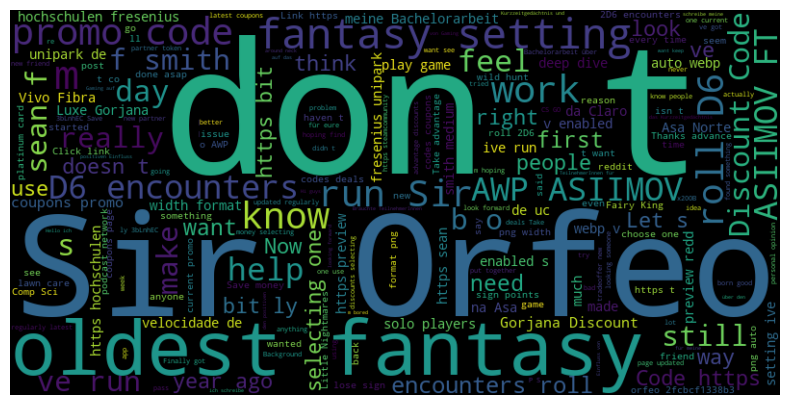

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

#set dataframe for wordcloud
#subdf = df[df["subreddit"]==subreddit]
subdf = df

#get stopwords
stop = stopwords.words('english')
#extend stopwords
stop.extend(['We','we','The','the','In','in','This','this','Also','also','These','these'])

# combine text from title and content
text = ' '.join(subdf['title']) + ' ' + ' '.join(subdf['content'])

# remove stopwords
words = text.split()
words = [w for w in words if w not in stop]
text = ' '.join(words)

# create wordcloud
wordcloud = WordCloud(width=800, height=400).generate(text)

# show wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Question-Answering-System

#### - on title and content

In [9]:
from transformers import pipeline

subdf = df[df["subreddit"]==subreddit]

text = ' '.join([f"{title} {content}" for title, content in zip(subdf['title'], subdf['content'])])
qa = pipeline(task="question-answering", model="distilbert-base-uncased-distilled-squad")

answer = qa(question="Who is hiring?", context=text)

print(answer)

{'score': 0.5096113085746765, 'start': 10684, 'end': 10693, 'answer': 'Redditors'}


In [11]:
#show context
range_of_context_lower = answer['start']-200 if answer['start']-200 >= 0 else 0
range_of_context_upper = answer['end']+300
context = text[range_of_context_lower:range_of_context_upper]
print(context)

ial condition, what’s the most weird or annoying thing you’ve been asked?  Those of you who "don't sound the way you look": what's the most awkward encounter/situation said juxtaposition has caused?  Redditors who are into fitness, what are your current goals?  What's the coolest way someone has turned you on?  what is your favourite car?  When did u think, yep im gonna die now?  Redditors with a facial difference/craniofacial condition, what’s the most weird or annoying thing you’ve been asked?  At what


#### - on table

In [82]:
from transformers import pipeline

tqa = pipeline(task="table-question-answering", model="google/tapas-large-finetuned-wtq")

print(tqa(table=df, query="Which subreddit is about Deep Instinct?"))

{'answer': 'golangjob', 'coordinates': [(10, 2)], 'cells': ['golangjob'], 'aggregator': 'NONE'}


In [86]:
df.head(11)

,title,content,subreddit
0,Do you think our (PGPL) league can ever develop?,I think it’s really hard to see our league dev...,teammelli
1,Boy in White,I know there is a theory that the BIW is Victo...,FromTVEpix
2,Two more methasterone doping cases - bad news ...,&#x200B;\n\n[https://www.insidethegames.biz/ar...,weightlifting
3,rule,,19684
4,Reddit is killing their brand in the worst pos...,,PoliticalVideo
5,Santa Claus coming for xqc's cookies,,livestreamfail_mirror
6,I Got My First Ever Gashapon In My Own Country...,,MagicalGirlsCommunity
7,ChatGPT made Blackwater Prologue Story for RDR...,I used ChatGPT to make this this blackwater pr...,reddeadredemption
8,"Deleted CPU drivers, PC is blue screening, saf...","I originally was with AMD, switched to Intel. ...",buildapc
9,Renter of the home we bought left us a housewa...,He threw a bunch of picture hanging nails down...,mildlyinfuriating


In [12]:
import gensim
from gensim import corpora

subdf = df[df["subreddit"]==subreddit]
#subdf = df

title_list = subdf['title'].tolist()
content_list = subdf['content'].tolist()
texts = title_list
texts.extend(content_list)
texts = [[word for word in doc.split() if word not in stop] for doc in texts]

# Erstellen des Wörterbuches
dictionary = corpora.Dictionary(texts)

# Erstellen des Corpus
corpus = [dictionary.doc2bow(text) for text in texts]

# Training des LDA-Modells
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10)

# Extrahieren der Themen und Wörter
topics = lda_model.print_topics(num_words=10)

for topic_id, topic in topics:
    topic_words = topic.split("+")
    topic_words = [word.split("*")[1].replace('"', '').strip() for word in topic_words]
    topic_words_str = ", ".join(topic_words)
    print(f"Topic {topic_id + 1}: {topic_words_str}")

Topic 1: account?, solidarity, To, I, protest, Reddits, comment, delete, ask, post
Topic 2: What, 2A, Republicans:, firearms?, open, thoughts, carry, allowing, fully-auto, permit-less
Topic 3: What, favorite, crypto, stock, why?, think, positive, made, society?, impact
Topic 4: why?, veterans,, better, changed, big, penis, point, /, site, worse
Topic 5: you?, How, subreddits, What, share, stories, read, people's, stories?, high
Topic 6: thing, what’s, Redditors, facial, condition,, asked?, annoying, you’ve, weird, different/craniofacial
Topic 7: What, Reddit, one, Wiki/index,, opinion, AskReddit, active, subs?, participate, get
Topic 8: How, stop, instead, go, Reddit, Instagram, history, want, People, dms
Topic 9: take, Why, let, [Serious], jobs?, AI, What's, on?, turned, someone
Topic 10: What's, recent, revival?, trend, worst, development, developers, disaster, start, reddit,
